<center><h1>ML models for daily AAPL Stock Price Forecasting</h1></center>  

Goal: Predict next-day close price for AAPL stock (daily regression)
Dataset: Daily OHLCV from Yahoo Finance, last 5 years (~1250 rows)
Pipeline: CSV download → preprocessing → train/test split → feature engineering → model → deployment
Serving & scaling: Expose API in Streamlit, handle multiple users
Monitoring: Track MAE/RMSE on latest predictions, detect drift
Tradeoffs & retraining: Decide update frequency (weekly/monthly), adjust features or model if performance drops  

Models:   
1) RandomForestRegression
2) XGBoostRegression


In [2]:
#import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from math import sqrt


## 1. Loading data

In [5]:

#data = yf.download("AAPL", period="5y", interval="1d", auto_adjust=False)

# saving the downloaded (on Oct_03, 2025) as csv file locally
# Flatten columns if they are multi-index
#if isinstance(data.columns, pd.MultiIndex):
#    # Keep only the second level (the actual data columns)
#data.columns = [col[0] if col[1] == 'AAPL' else col[1] for col in data.columns]
#data.to_csv("AAPL_5y_daily.csv") 

In [7]:
# downloaded data from csv file
data = pd.read_csv("AAPL_5y_daily.csv", index_col=[0], parse_dates=True)
data = data.rename(columns={'Adj Close': 'Adj_Close'})
data.tail()

,Adj_Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-09-29,254.429993,254.429993,255.000000,253.009995,254.559998,40127700
2025-09-30,254.630005,254.630005,255.919998,253.110001,254.860001,37704300
2025-10-01,255.449997,255.449997,258.790009,254.929993,255.039993,48713900
2025-10-02,257.130005,257.130005,258.179993,254.149994,256.579987,42630200
2025-10-03,258.019989,258.019989,259.239990,253.949997,254.669998,49107000



# ML models 

'''For RandomForest / XGBoost:

We’ll use many features, including:  
OHLCV columns;  
Lag features (previous price values);  
Rolling means, std, etc;  
Date-based features (day, month, etc.);  

No differencing or manual “stationarizing.”  
The ML models will learn the patterns directly.'''



In [11]:
# Data:
data.info()
data.isna().sum()
data = data.dropna()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-10-05 to 2025-10-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj_Close  1256 non-null   float64
 1   Close      1256 non-null   float64
 2   High       1256 non-null   float64
 3   Low        1256 non-null   float64
 4   Open       1256 non-null   float64
 5   Volume     1256 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.7 KB


,Adj_Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-10-05,113.321625,116.500000,116.650002,113.550003,113.910004,106243800
2020-10-06,110.072739,113.160004,116.120003,112.250000,115.699997,161498200
2020-10-07,111.940361,115.080002,115.550003,114.129997,114.620003,96849000
2020-10-08,111.833382,114.970001,116.400002,114.589996,116.250000,83477200
2020-10-09,113.778793,116.970001,117.000000,114.919998,115.279999,100506900


### Feature engineering

In [14]:

# To be sure that the data chronogically ordered: 
data = data.sort_values('Date')

# Creating multiple lag features
lags = [1, 2, 3, 5, 10, 20]
for lag in lags:
    data[f'lag_{lag}'] = data['Adj_Close'].shift(lag)

# Drop NaN from early rows appeared due to the lag features.
data = data.dropna()
data.head()

,Adj_Close,Close,High,Low,Open,Volume,lag_1,lag_2,lag_3,lag_5,lag_10,lag_20
Date,,,,,,,,,,,,
2020-11-02,105.802521,108.769997,110.680000,107.320000,109.110001,122866900,105.890045,112.173805,108.166222,111.911179,112.815804,113.321625
2020-11-03,107.426964,110.440002,111.489998,108.730003,109.660004,107624400,105.802521,105.890045,112.173805,113.418884,114.304054,110.072739
2020-11-04,111.813911,114.949997,115.589996,112.349998,114.139999,138235500,107.426964,105.802521,105.890045,108.166222,113.681526,111.940361
2020-11-05,115.782578,119.029999,119.620003,116.870003,117.949997,126387100,111.813911,107.426964,105.802521,112.173805,112.592087,111.833382
2020-11-06,115.651077,118.690002,119.199997,116.129997,118.320000,114457900,115.782578,111.813911,107.426964,105.890045,111.901459,113.778793


#### Preparing features and target, split data: 

In [17]:
# Features, target — NEXT DAY RETURN

# Target: next-day price (in dollars)
data['target'] = data['Adj_Close'].shift(-1)

# Drop NaN rows
data = data.dropna()

# Define features and target
X = data[[f'lag_{lag}' for lag in lags]]
y = data['target']

# splitting
train_end = int(len(data) * 0.8)              # 80% for training
val_end = int(len(data) * 0.9)                # next 10% for validation

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 988, Val: 123, Test: 124


## RandomForest model

In [20]:
# Predict on validation data

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

#  Evaluate on validation set

y_pred_val = model.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)

print(f"\nValidation RMSE: ${rmse_val:.2f}")
print(f"Validation MAE:  ${mae_val:.2f}")



Validation RMSE: $16.36
Validation MAE:  $13.18


### Hyperparameter tuning for optimization


In [23]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV MAE: ", -grid.best_score_)

best_rf = grid.best_estimator_



Best Parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500}
Best CV MAE:  10.0782703529597


In [25]:
# Evaluate tuned model on validation

y_pred_val_best = best_rf.predict(X_val)

rmse_val_best = sqrt(mean_squared_error(y_val, y_pred_val_best))
mae_val_best = mean_absolute_error(y_val, y_pred_val_best)

print(f"\nTuned Validation RMSE: ${rmse_val_best:.2f}")
print(f"Tuned Validation MAE:  ${mae_val_best:.2f}")



Tuned Validation RMSE: $16.73
Tuned Validation MAE:  $13.51


In [27]:
# Retrain on (train + val) and evaluate on test

X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

best_rf.fit(X_trainval, y_trainval)

y_pred_test = best_rf.predict(X_test)

rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"\nFinal Test RMSE: ${rmse_test:.3f}")
print(f"Final Test MAE:  ${mae_test:.3f}")



Final Test RMSE: $8.076
Final Test MAE:  $6.451


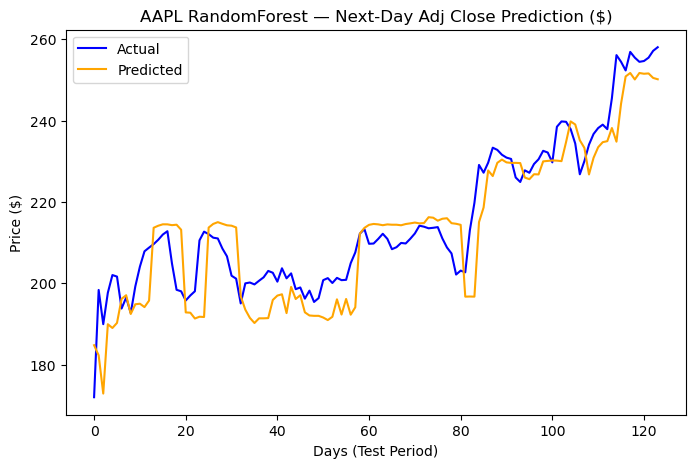

In [29]:

# Plot actual vs predicted prices

plt.figure(figsize=(8,5))
plt.plot(y_test.values, label="Actual", color='blue')
plt.plot(y_pred_test, label="Predicted", color='orange')
plt.title("AAPL RandomForest — Next-Day Adj Close Prediction ($)")
plt.xlabel("Days (Test Period)")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

## XGBoost model

In [32]:

# Baseline XGBoost Model (no tuning yet)
# -------------------------------------
from xgboost import XGBRegressor

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5
)

xgb_base.fit(X_train, y_train)

# Validation predictions
y_pred_val_xgb_base = xgb_base.predict(X_val)
rmse_val_xgb_base = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb_base))
mae_val_xgb_base = mean_absolute_error(y_val, y_pred_val_xgb_base)

# Test predictions
y_pred_test_xgb_base = xgb_base.predict(X_test)
rmse_test_xgb_base = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb_base))
mae_test_xgb_base = mean_absolute_error(y_test, y_pred_test_xgb_base)

print("Baseline XGBoost:")
print(f"\nValidation: \nRMSE: {rmse_val_xgb_base:.6f}, \nMAE: {mae_val_xgb_base:.3f}")
print(f"\nTest: \nRMSE: {rmse_test_xgb_base:.6f}, \nMAE: {mae_test_xgb_base:.3f}")



Baseline XGBoost:

Validation: 
RMSE: 21.657330, 
MAE: 18.238

Test: 
RMSE: 15.740593, 
MAE: 11.182


### Hyperparameter tuning

In [35]:

# Hyperparameter Tuning with GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid_xgb,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("\nBest Parameters:", grid_xgb.best_params_)
print("Best CV MAE:", -grid_xgb.best_score_)

xgb_best = grid_xgb.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV MAE: 10.603254988135362


In [37]:

# Evaluate on Validation Set

y_pred_val_xgb_tuned = xgb_best.predict(X_val)
rmse_val_xgb_tuned = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb_tuned))
mae_val_xgb_tuned = mean_absolute_error(y_val, y_pred_val_xgb_tuned)

print("\nTuned XGBoost Validation:")
print(f"RMSE (Val): {rmse_val_xgb_tuned:.3f}")
print(f"MAE (Val):  {mae_val_xgb_tuned:.3f}")


Tuned XGBoost Validation:
RMSE (Val): 16.722
MAE (Val):  13.469


In [39]:

# Retrain on (Train + Val) and Test Evaluation

X_trainval_xgb = pd.concat([X_train, X_val])
y_trainval_xgb = pd.concat([y_train, y_val])

xgb_best.fit(X_trainval_xgb, y_trainval_xgb)

y_pred_test_xgb_tuned = xgb_best.predict(X_test)
rmse_test_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb_tuned))
mae_test_xgb_tuned = mean_absolute_error(y_test, y_pred_test_xgb_tuned)

print("\nFinal Tuned XGBoost Test Results:")
print(f"RMSE (Test): {rmse_test_xgb_tuned:.3f}")
print(f"MAE (Test):  {mae_test_xgb_tuned:.3f}")



Final Tuned XGBoost Test Results:
RMSE (Test): 7.214
MAE (Test):  5.653


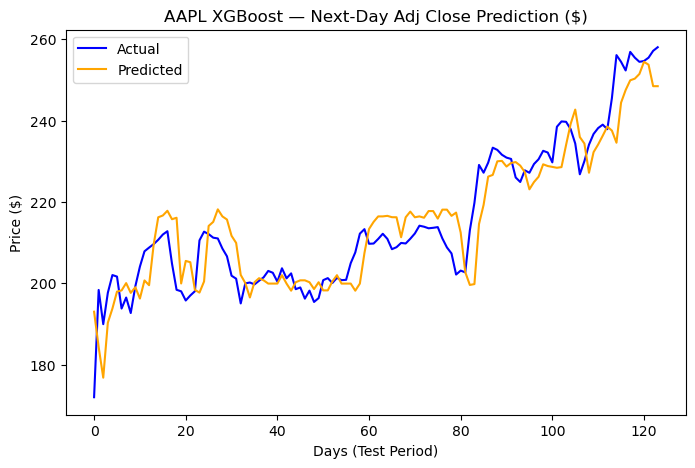

In [41]:

# Plot actual vs predicted prices

plt.figure(figsize=(8,5))
plt.plot(y_test.values, label="Actual", color='blue')
plt.plot(y_pred_test_xgb_tuned, label="Predicted", color='orange')
plt.title("AAPL XGBoost — Next-Day Adj Close Prediction ($)")
plt.xlabel("Days (Test Period)")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

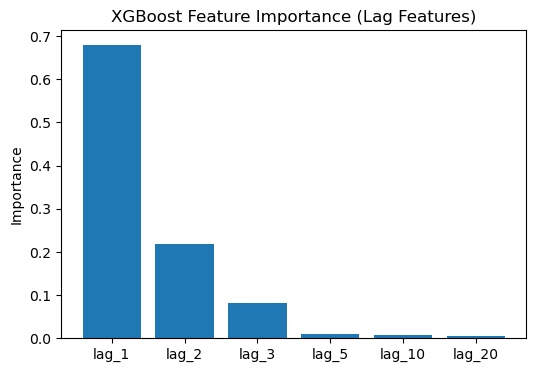

In [43]:
# to check which lags are important: 

importances = xgb_best.feature_importances_
plt.figure(figsize=(6,4))
plt.bar(range(len(importances)), importances, tick_label=[f'lag_{l}' for l in [1,2,3,5,10,20]])
plt.title("XGBoost Feature Importance (Lag Features)")
plt.ylabel("Importance")
plt.show()

## Conclusions.

#### Both RandomForest and XGBoost show better performance than SARIMA TSA model. Also, XGBoost model shows slightly better performance compared to RandomForest model:

#### Final Tuned RandomForest Test Results:  
Final Test RMSE: 8.076  
Final Test MAE:  6.451

#### Final Tuned XGBoost Test Results:  
RMSE (Test): 7.214  
MAE (Test):  5.653